In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
image_dir = Path('dataset')

In [4]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


image_df = pd.concat([filepaths, labels], axis=1)


In [5]:
labels

0       Iceberg
1       Iceberg
2       Iceberg
3       Iceberg
4       Iceberg
         ...   
1599       Ship
1600       Ship
1601       Ship
1602       Ship
1603       Ship
Name: Label, Length: 1604, dtype: object

In [6]:
image_df

,Filepath,Label
0,dataset\Iceberg\f10.png,Iceberg
1,dataset\Iceberg\f1001.png,Iceberg
2,dataset\Iceberg\f1003.png,Iceberg
3,dataset\Iceberg\f1004.png,Iceberg
4,dataset\Iceberg\f1005.png,Iceberg
...,...,...
1599,dataset\Ship\f986.png,Ship
1600,dataset\Ship\f993.png,Ship
1601,dataset\Ship\f996.png,Ship
1602,dataset\Ship\f997.png,Ship


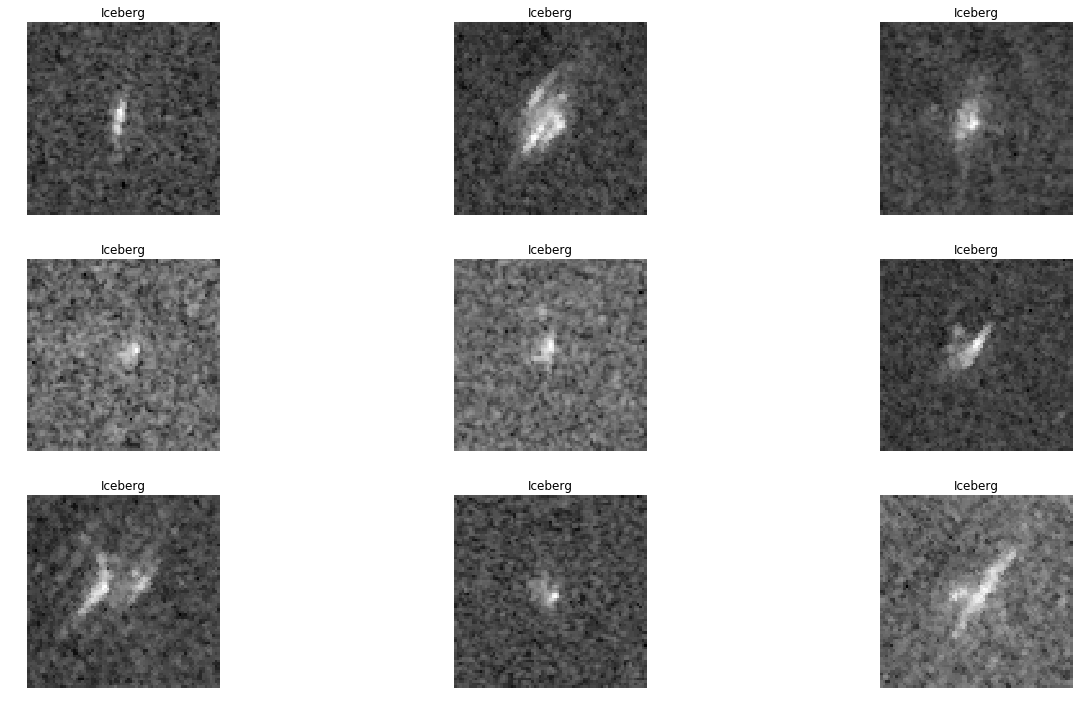

In [28]:
positive = os.listdir("dataset/iceberg")
positive_dir = "dataset/iceberg"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(positive_dir, positive[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Iceberg") 
    
plt.tight_layout()

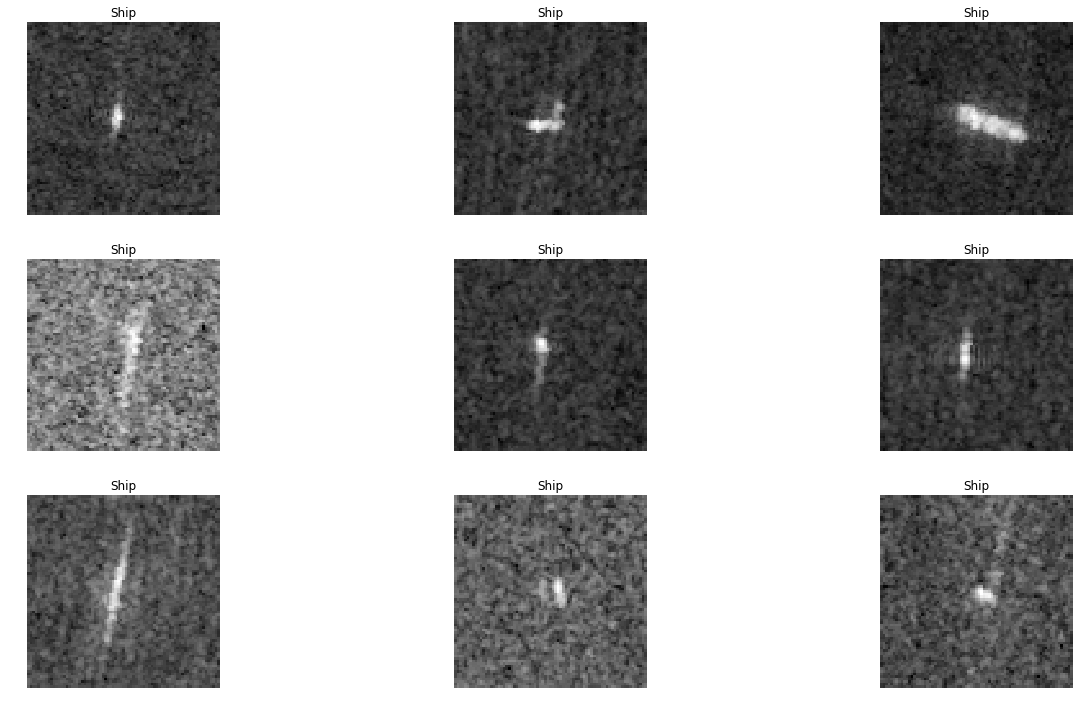

In [29]:
Ship = os.listdir("dataset/Ship")
Ship_dir = "dataset/Ship"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(Ship_dir, Ship[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Ship") 
    
plt.tight_layout()

In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.75, shuffle=True, random_state=1)

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(64,64),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)



test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(64,64),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 963 validated image filenames belonging to 2 classes.
Found 401 validated image filenames belonging to 2 classes.


In [26]:
inputs = tf.keras.Input(shape=(64, 64, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=test_images,
    epochs=100
)

Epoch 1/100
31/31 [==============================] - 3s 86ms/step - loss: 0.6915 - accuracy: 0.5317 - val_loss: 0.6803 - val_accuracy: 0.5212
Epoch 2/100
31/31 [==============================] - 3s 81ms/step - loss: 0.6826 - accuracy: 0.5576 - val_loss: 0.6925 - val_accuracy: 0.4613
Epoch 3/100
31/31 [==============================] - 3s 82ms/step - loss: 0.6742 - accuracy: 0.5369 - val_loss: 0.6541 - val_accuracy: 0.7232
Epoch 4/100
31/31 [==============================] - 3s 82ms/step - loss: 0.6222 - accuracy: 0.6521 - val_loss: 0.6036 - val_accuracy: 0.7057
Epoch 5/100
31/31 [==============================] - 2s 80ms/step - loss: 0.6780 - accuracy: 0.5327 - val_loss: 0.6485 - val_accuracy: 0.5486
Epoch 6/100
31/31 [==============================] - 3s 83ms/step - loss: 0.6167 - accuracy: 0.6417 - val_loss: 0.6107 - val_accuracy: 0.6683
Epoch 7/100
31/31 [==============================] - 3s 82ms/step - loss: 0.5574 - accuracy: 0.7103 - val_loss: 0.5138 - val_accuracy: 0.7307
Epoch 

In [24]:
evaluation = model.evaluate(test_images)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_images)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

13/13 [==============================] - 0s 19ms/step - loss: 0.2903 - accuracy: 0.8953
Test Accuracy: 89.53%
31/31 [==============================] - 2s 50ms/step - loss: 0.2911 - accuracy: 0.8567
Train Accuracy: 85.67%


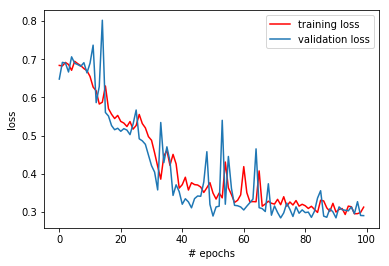

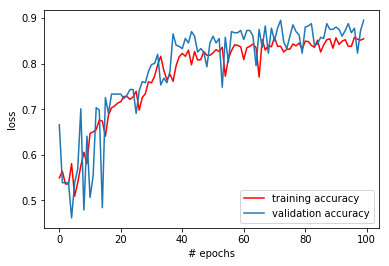

In [25]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


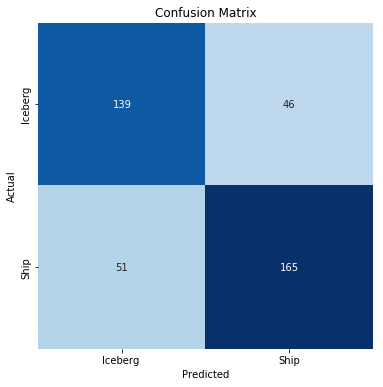

Classification Report:
----------------------
                  precision    recall  f1-score   support

Covid Positive        0.73      0.75      0.74       185
 Covid Negative       0.78      0.76      0.77       216

      micro avg       0.76      0.76      0.76       401
      macro avg       0.76      0.76      0.76       401
   weighted avg       0.76      0.76      0.76       401



In [13]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["Covid Positive ", "Covid Negative"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["Iceberg ", "Ship"])
plt.yticks(ticks=[0.5, 1.5], labels=["Iceberg", "Ship"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


In [14]:
from tensorflow.keras.models import load_model

model.save('Iceberg.h5')
from tensorflow.keras.models import load_model
 
# load model
# model = load_model('model_rcat_dog.h5')

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test_images)

print(confusion_matrix(test_images.classes, pred > 0.5))
pd.DataFrame(classification_report(test_images.classes, pred > 0.5, output_dict=True))

[[161  24]
 [ 22 194]]


,0,1,micro avg,macro avg,weighted avg
precision,0.879781,0.889908,0.885287,0.884845,0.885236
recall,0.870270,0.898148,0.885287,0.884209,0.885287
f1-score,0.875000,0.894009,0.885287,0.884505,0.885239
support,185.000000,216.000000,401.000000,401.000000,401.000000


In [32]:
print(confusion_matrix(test_images.classes, pred > 0.7))
pd.DataFrame(classification_report(test_images.classes, pred > 0.7, output_dict=True))

[[171  14]
 [ 52 164]]


,0,1,micro avg,macro avg,weighted avg
precision,0.766816,0.921348,0.835411,0.844082,0.850055
recall,0.924324,0.759259,0.835411,0.841792,0.835411
f1-score,0.838235,0.832487,0.835411,0.835361,0.835139
support,185.000000,216.000000,401.000000,401.000000,401.000000
